## 필요한 모듈 임포트

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle

`from sklearn.preprocessing import Imputer` 실행 시 오류가 발생한다. Imputer를 불러오기 위해서는 `sklearn.impute`를 사용해 `SimpleImputer`를 불러오면 된다.
([링크](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html?highlight=simpleimputer#sklearn.impute.SimpleImputer))

In [60]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
test.shape

(625134, 9)

## 데이터 클리닝
### 결측치 확인

In [61]:
train[pd.isnull(train)].sum()

id                    0  
vendor_id             0.0
pickup_datetime       0  
dropoff_datetime      0  
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag    0  
trip_duration         0.0
dtype: object

결측치는 존재하지 않는다.
### 시계열 데이터 타입 변경

In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [63]:
train['pickup_datetime'].head()

0    2016-03-14 17:24:55
1    2016-06-12 00:43:35
2    2016-01-19 11:35:24
3    2016-04-06 19:32:31
4    2016-03-26 13:30:55
Name: pickup_datetime, dtype: object

`pickup_datetime`, `dropoff_datetime` 변수는 시계열 데이터처럼 보이지만, 실제 데이터 타입은 `float64`이다. 따라서 이를 시계열 데이터 타입으로 변경해 준다.

In [64]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


`pickup_datetime`과 `dropoff_datetime`의 데이터 타입이 `datetime64`로 변경된 것을 확인할 수 있다.
### 시계열 범위 확인

In [65]:
print("Min pickup time:", min(train['pickup_datetime']))
print("Max pickup time:", max(train['pickup_datetime']))

Min pickup time: 2016-01-01 00:00:17
Max pickup time: 2016-06-30 23:59:39


2016년 1월부터 2016년 6월까지의 데이터임을 확인할 수 있다.
### 시계열 데이터에서 일자(YYYY-MM-DD), 일, 시간, 요일 분리

In [66]:
train['pickup_date'] = train['pickup_datetime'].dt.date
train['pickup_day'] = train['pickup_datetime'].apply(lambda x:x.day)
train['pickup_hour'] = train['pickup_datetime'].apply(lambda x:x.hour)
train['pickup_day_of_week'] = train['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
train['dropoff_date'] = train['dropoff_datetime'].dt.date
train['dropoff_day'] = train['dropoff_datetime'].apply(lambda x:x.day)
train['dropoff_hour'] = train['dropoff_datetime'].apply(lambda x:x.hour)
train['dropoff_day_of_week'] = train['dropoff_datetime'].apply(lambda x:calendar.day_name[x.weekday()])

### 일부 변수를 소수점 셋째 자리까지만 표현

In [67]:
train['pickup_latitude_round3'] = train['pickup_latitude'].apply(lambda x:round(x,3))
train['pickup_longitude_round3'] = train['pickup_longitude'].apply(lambda x:round(x,3))
train['dropoff_latitude_round3'] = train['dropoff_latitude'].apply(lambda x:round(x,3))
train['dropoff_longitude_round3'] = train['dropoff_longitude'].apply(lambda x:round(x,3))

train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,17,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,11,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,19,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,13,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973


### 위도와 경도 정보를 바탕으로 거리 계산
하버사인 거리(Haversine distance)를 이용

In [68]:
def calculateDistance(row):
    R = 6373.0 # 지구 반지름의 대략적인 길이
    pickup_lat = radians(row['pickup_latitude'])
    pickup_lon = radians(row['pickup_longitude'])
    dropoff_lat = radians(row['dropoff_latitude'])
    dropoff_lon = radians(row['dropoff_longitude'])
    dlon = dropoff_lon - pickup_lon
    dlat = dropoff_lat - pickup_lat
    a = sin(dlat / 2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance

train['trip_distance'] = train.apply(lambda row:calculateDistance(row), axis=1)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962


### 주행 시간을 시간 단위로 변환

In [69]:
train['trip_duration_in_hour'] = train['trip_duration'].apply(lambda x:x/3600)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991,0.126389
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074,0.184167
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103,0.590000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965,0.119167
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962,0.120833


## EDA

In [70]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 25 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   id                        1458644 non-null  object        
 1   vendor_id                 1458644 non-null  int64         
 2   pickup_datetime           1458644 non-null  datetime64[ns]
 3   dropoff_datetime          1458644 non-null  datetime64[ns]
 4   passenger_count           1458644 non-null  int64         
 5   pickup_longitude          1458644 non-null  float64       
 6   pickup_latitude           1458644 non-null  float64       
 7   dropoff_longitude         1458644 non-null  float64       
 8   dropoff_latitude          1458644 non-null  float64       
 9   store_and_fwd_flag        1458644 non-null  object        
 10  trip_duration             1458644 non-null  int64         
 11  pickup_date               1458644 non-null  object

### 주행 시간의 분포는?
주행 시간은 `trip_duration` 변수(초 단위) 혹은 새로 생성상 `trip_duration_in_hour` 변수(시간 단위)로 확인할 수 있다. 편의상 시간 단위로 확인한다.

Text(0.5, 0, 'Trip duration (in hour)')

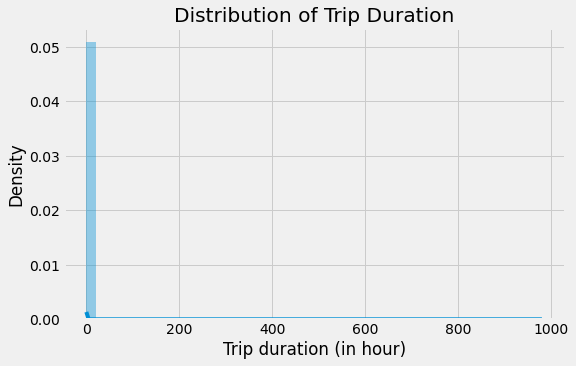

In [71]:
plt.figure(figsize=(8,5))
sns.distplot(train['trip_duration_in_hour']).set_title("Distribution of Trip Duration")
plt.xlabel("Trip duration (in hour)")

주행 시간이 24시간이 넘어가는 경우가 있을까?

In [72]:
outlier_trip_duration = train.loc[train['trip_duration_in_hour']>24]
outlier_trip_duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,...,2016-01-27,27,11,Wednesday,40.644,-73.790,40.773,-73.957,20.154989,538.815556
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,...,2016-03-08,8,15,Tuesday,40.735,-73.922,40.760,-73.985,5.984365,569.327222
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,...,2016-01-31,31,1,Sunday,40.742,-73.984,40.728,-73.985,1.635641,618.781111
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,...,2016-03-25,25,18,Friday,40.649,-73.784,40.750,-73.978,19.906909,979.522778


주행 시간이 매우 길지만 주행 거리는 짧은 편이므로, 실 주행이라 보기 어렵다(outlier). 하지만 분석에서는 제외하지 않기로 한다.

분포가 매우 skew 되어 있다. log scale 으로 변환한 다음 분포를 확인해 보자.

Text(0.5, 1.0, 'Distribution of trip duration (sec) in Log Scale')

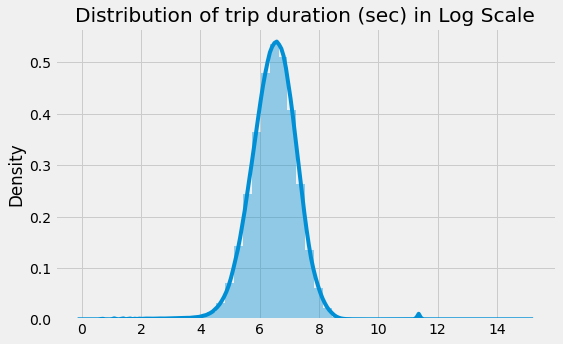

In [73]:
plt.figure(figsize=(8,5))
sns.distplot(np.log(train['trip_duration'].values)).set_title("Distribution of Trip Duration")
plt.title("Distribution of trip duration (sec) in Log Scale")

log scale 을 한 결과 정규분포의 모양을 따르며 대부분의 주행은 $$exp(4)$$와 $$exp(8)$$, 즉 1시간 내외임을 확인할 수 있다.

✔ 택시는 대부분 한시간 내외로 타는구나!

### 사람들은 보통 몇시에 택시를 타고 내릴까?
택시 승하차 시간의 분포는 `pickup_hour`와 `dropoff_hour` 변수의 분포를 통해 확인할 수 있다.

Text(0.5, 1.0, 'Pickup Hours Duration')

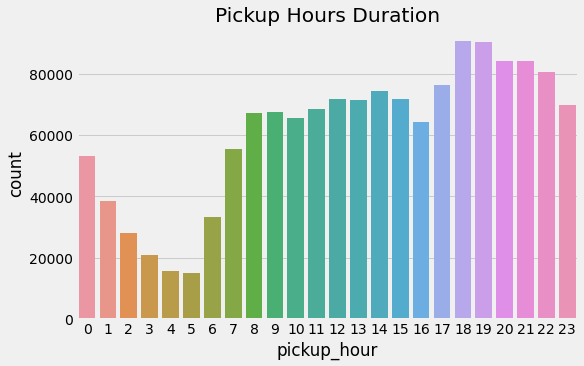

In [74]:
plt.figure(figsize=(8,5))
sns.countplot(x=train['pickup_hour']).set_title("Pickup Hours Duration")

Text(0.5, 1.0, 'Dropoff Hours Duration')

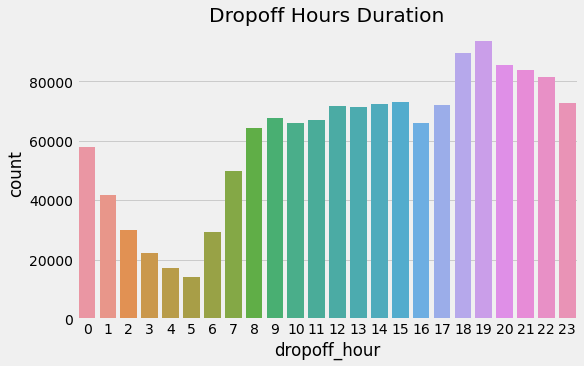

In [75]:
plt.figure(figsize=(8,5))
sns.countplot(x=train['dropoff_hour']).set_title("Dropoff Hours Duration")

✔ 택시 승하차 시간의 분포는 상당히 유사하구나!
### 매일매일 택시 승차 수는 얼마나 될까?
`pickup_date` 변수를 이용해서 확인해 보자.

Text(0.5, 1.0, 'Distribution of Pickups over time')

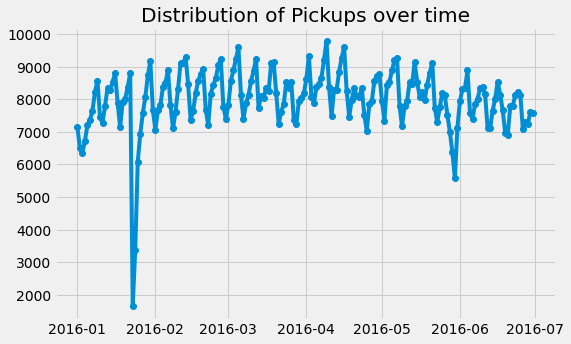

In [76]:
plt.figure(figsize=(8,5))
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.title("Distribution of Pickups over time")

✔ 2016년 1월 말에 큰 drop이 있었다! (❗ Time Series Component 에 대한 decomposition 생각해 보기)
### 주행 거리의 분포는?

Text(0.5, 0, 'Trip Distance')

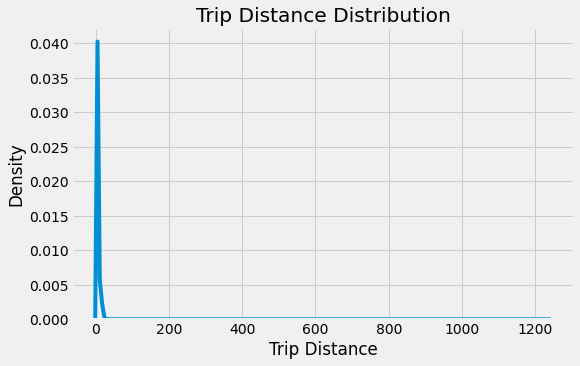

In [77]:
plt.figure(figsize=(8,5))
sns.kdeplot(train['trip_distance'].values).set_title("Trip Distance Distribution")
plt.xlabel("Trip Distance")

주행 시간과 마찬가지로 매우 skew 되어 있다. log scale 을 취해서 변환하도록 해 보자.

Text(0.5, 0, 'Trip Distance (log)')

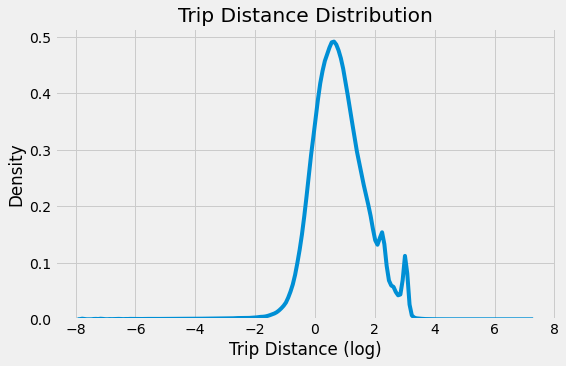

In [80]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train['trip_distance'].values)).set_title("Trip Distance Distribution")
plt.xlabel("Trip Distance (log)")

log scale 을 취해서 보니 정규분포를 따르는 것처럼 보인다.

✔ 대부분의 주행은 $$exp(3)$$ 즉 대략 20km 내외!
### 주행 시간과 주행 거리의 관계는?

Text(0, 0.5, 'Trip Duration (log scale)')

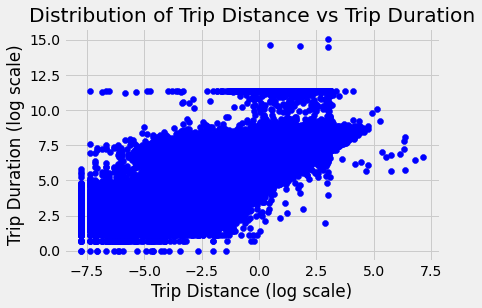

In [81]:
plt.scatter(np.log(train['trip_distance'].values), np.log(train['trip_duration'].values),
            color='blue', label='train')
plt.title("Distribution of Trip Distance vs Trip Duration")
plt.xlabel("Trip Distance (log scale)")
plt.ylabel("Trip Duration (log scale)")

✔ 로그를 씌운 주행 시간과 거리 간에는 양의 상관관계가 존재하는 것 같아!
### 택시를 타는 시간에 따라 주행 시간에 변화가 있을까?

Text(0.5, 1.0, 'Distribution of trip duration by hours')

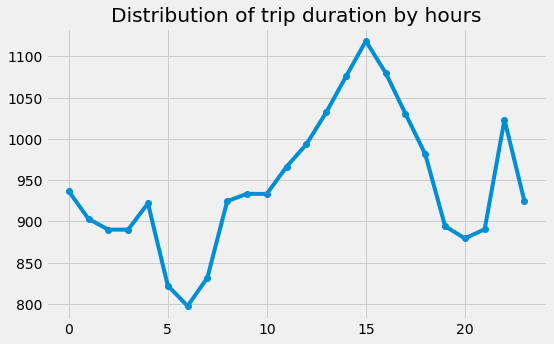

In [83]:
avg_duration_hour = train.groupby(['pickup_hour'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})
plt.figure(figsize=(8,5))
plt.plot(train.groupby(['pickup_hour'])['trip_duration'].mean(), 'o-')
plt.title("Distribution of trip duration by hours")

✔ 10시-15시에 택시를 타면 평균 주행 시간이 더 길어지는 경향이 존재해!
### 무슨 요일에 택시를 많이 탈까?
새롭게 만든 `pickup_day_of_week` 변수를 사용해 보자

Text(0.5, 0, 'Pickup day of week')

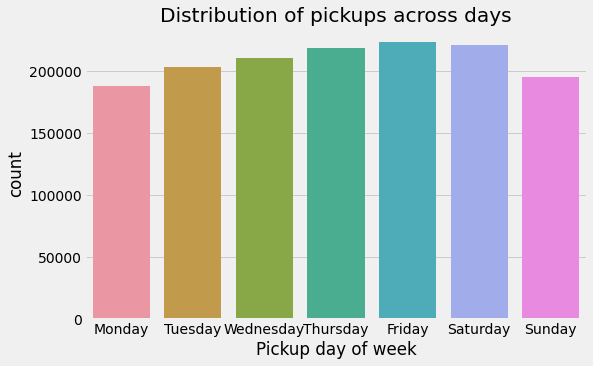

In [84]:
plt.figure(figsize=(8,5))
sns.countplot(train['pickup_day_of_week'], order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Distribution of pickups across days")
plt.xlabel("Pickup day of week")

✔ 월요일~금요일까지 택시 이용자가 증가하는 추세!

✔ 일요일, 월요일에 택시를 적게 타는 경향
### 무슨 요일에 목적지까지 도착 시간이 제일 짧을까?

In [85]:
avg_duration_day = train.groupby(['pickup_day_of_week'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})

Text(0.5, 1.0, 'Avg Trip Duration vs Pickup Days of Week')

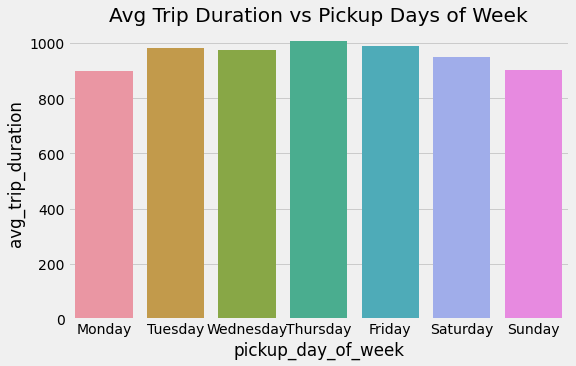

In [88]:
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_day_of_week', y='avg_trip_duration', data=avg_duration_day,
            order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']).set_title("Avg Trip Duration vs Pickup Days of Week")

✔ 일요일, 월요일에 목적지까지 걸리는 시간이 짧다!
### Bearing과 주행 시간의 비교
> In mathematics, a bearing is the angle in degrees measured clockwise from north. Bearings are usually given as a three-figure bearing. For example, 30° clockwise from north is usually written as 030°
>
Bearing은 움직임의 방향을 측정하는 지표로, 위도(경도) λ에 대해 θ = atan2( sin Δλ ⋅ cos φ2 , cos φ1 ⋅ sin φ2 − sin φ1 ⋅ cos φ2 ⋅ cos Δλ ) 라는 공식으로 계산 가능하다.

In [89]:
def calculateBearing(lat1,lng1,lat2,lng2):
    R = 6371
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [91]:
train['bearing']=train.apply(lambda row:calculateBearing(row['pickup_latitude_round3'],row['pickup_longitude_round3'],row['dropoff_latitude_round3'],row['dropoff_longitude_round3']),axis=1)

<AxesSubplot:xlabel='bearing', ylabel='Density'>

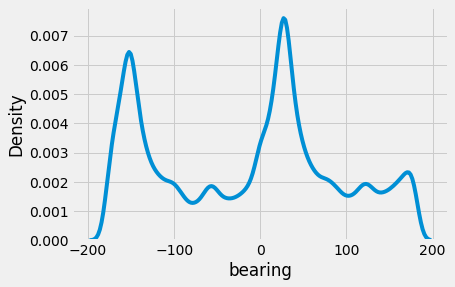

In [92]:
sns.kdeplot(train['bearing'])

✔ Bearing의 각도는 -150과 30 부근에서 높은 쌍봉형 분포를 이루고 있다.

Text(0, 0.5, 'Trip Duration (log scale)')

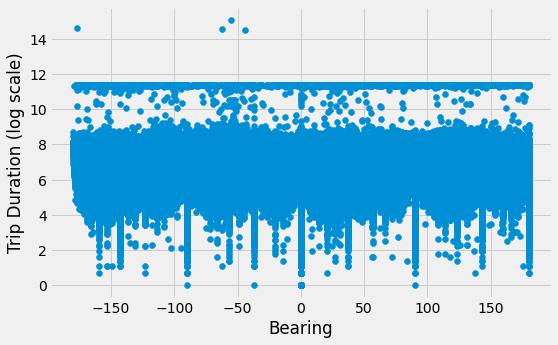

In [93]:
plt.figure(figsize=(8,5))
plt.scatter(train['bearing'].values, y=np.log(train['trip_duration'].values))
plt.xlabel("Bearing")
plt.ylabel("Trip Duration (log scale)")

✔ Bearing이 -50 근처인 부근에서 주행 시간의 이상치가 존재한다!
### Store and FWD에 따른 주행 시간의 차이 비교

In [96]:
train['store_and_fwd_flag'].value_counts()

N    1450599
Y    8045   
Name: store_and_fwd_flag, dtype: int64

마찬가지로 분포가 skew 되어 있기 때문에 log scale 을 취해서 분석한다.

Text(0, 0.5, 'Density')

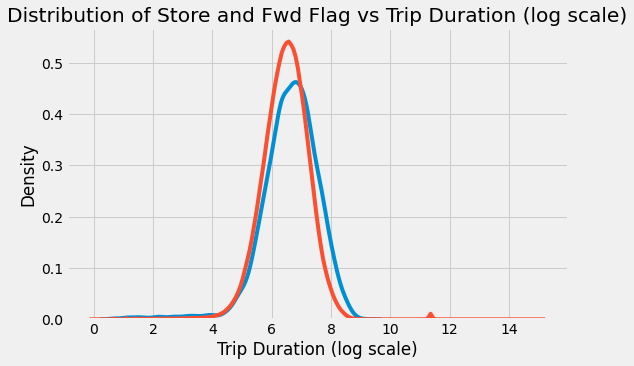

In [97]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag']=='Y', 'trip_duration'].values),label='Store and Fwd = Yes')
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag']=='N', 'trip_duration'].values),label='Store and Fwd = No')
plt.title("Distribution of Store and Fwd Flag vs Trip Duration (log scale)")
plt.xlabel("Trip Duration (log scale)")
plt.ylabel("Density")

✔ 기록 유무에 따라 주행 거리의 분포 양상이 큰 차이가 있지는 않는다!
### 특정 군집(지역)에서 승차하면 주행 시간이 더 길어지는 경향이 있을까?

(-74.03, -73.75)

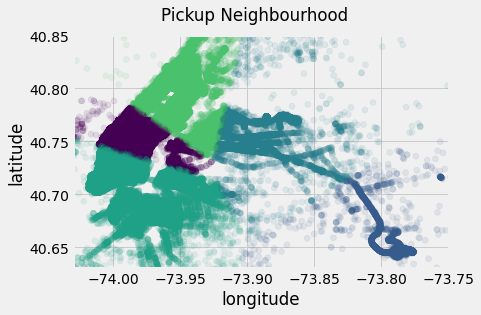

In [102]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))
kmeans = KMeans(n_clusters=8, random_state=0).fit(coords)
train.loc[:, 'pickup_neighbourhood'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
              c=train['pickup_neighbourhood'], label='train', alpha=0.1)

fig.suptitle('Pickup Neighbourhood')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

나눈 8개의 군집별로 얼마나 승차가 이루어졌는지 막대 그래프로 비교하자.

Text(0.5, 1.0, 'Distribution of Number of Pickups across Neighborhoods')

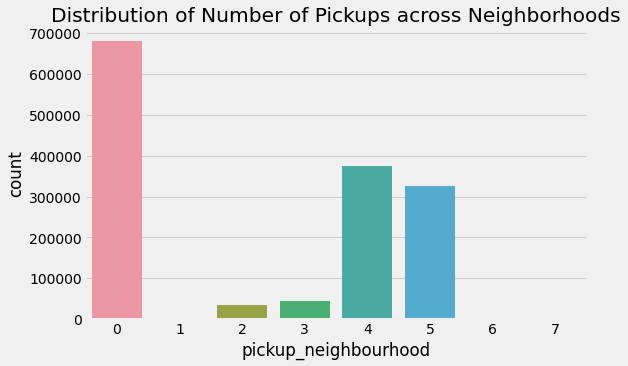

In [103]:
plt.figure(figsize=(8,5))
sns.countplot(train['pickup_neighbourhood']).set_title("Distribution of Number of Pickups across Neighborhoods")

✔ 군집별로 승차 수에 차이가 극명하게 존재!

Text(0.5, 1.0, 'Avg Trip Duration vs Neighbourhood')

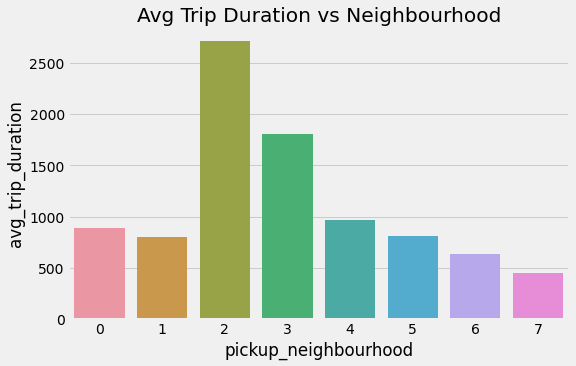

In [104]:
avg_duration_neighbourhood = train.groupby(['pickup_neighbourhood'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_neighbourhood',y='avg_trip_duration',data=avg_duration_neighbourhood).set_title("Avg Trip Duration vs Neighbourhood")

✔ 군집 0에서 승차 수가 제일 많았지만, 군집 2에서 승차 시간이 제일 길다!
### 택시의 평균 속도는?

Text(0.5, 1.0, 'Distribution of Average Speed (in kph)')

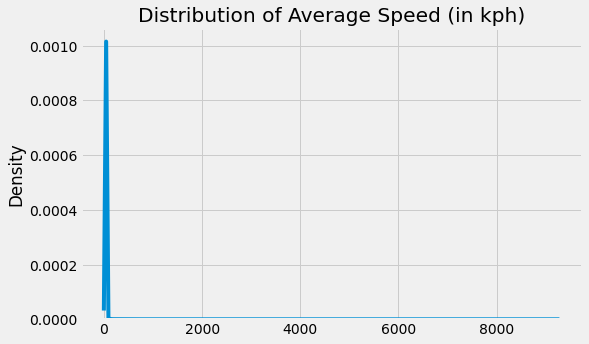

In [105]:
train['avg_speed_kph'] = train['trip_distance'] / train['trip_duration_in_hour']
plt.figure(figsize=(8,5))
sns.kdeplot(train['avg_speed_kph'].values).set_title("Distribution of Average Speed (in kph)")

In [108]:
train['avg_speed_kph'].describe()

count    1.458644e+06
mean     1.442774e+01
std      1.498223e+01
min      0.000000e+00
25%      9.124138e+00
50%      1.279599e+01
75%      1.785051e+01
max      9.277748e+03
Name: avg_speed_kph, dtype: float64

In [109]:
train['avg_speed_kph'].mean()

14.427736738459107

✔ 택시의 평균 속도는 약 14km!
### 택시의 평균 속도의 요일별 분포는?

Text(0.5, 1.0, 'Avg Speed (kph) vs Pickup Days of Week')

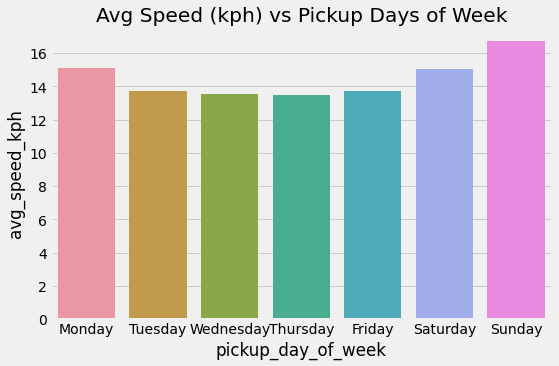

In [110]:
avg_speed_per_day = train.groupby(['pickup_day_of_week'])['avg_speed_kph'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_day_of_week', y='avg_speed_kph', data=avg_speed_per_day, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).set_title('Avg Speed (kph) vs Pickup Days of Week')

✔ 평균 속도는 일요일과 월요일에 가장 높다!

## EDA 인사이트 요약
- 택시는 대부분 한시간 내외로 탑승
- 택시 승하차 시간의 분포는 상당히 유사
- 택시 승차 수는 2016년 1월 말에 큰 drop이 존재했음
- 대부분의 주행은 대략 20km 내외
- 로그를 씌운 주행 시간과 거리 간에는 양의 상관관계가 존재
- 10시-15시에 택시를 타면 평균 주행 시간이 더 길어지는 경향이 존재
- 월요일~금요일까지 택시 이용자가 증가하는 추세
- 일요일, 월요일에 택시를 적게 타는 경향
- 일요일, 월요일에 목적지까지 걸리는 시간이 짧음
- Bearing의 각도는 -150과 30 부근에서 높은 쌍봉형 분포를 이루고 있음
- Bearing이 -50 근처인 부근에서 주행 시간의 이상치가 존재
- 기록 유무에 따라 주행 거리의 분포 양상이 큰 차이가 있지는 않음
- 승차 지역의 군집별로 승차 수에 차이가 극명하게 존재
- 군집 0에서 승차 수가 제일 많았지만, 군집 2에서 승차 시간이 제일 긺
- 택시의 평균 속도는 약 14km